# 텀 프로젝트 외전 <비트코인을 예측해보아요>

그렇다면 이번엔 진짜로 비트코인 예측을 해봐야지 않겠는가?
지난 30일간의 시가,종가,고가,저가,변동률의 데이터로 내일의 종가를 예측해주는 딥러닝 모델을 만들어보자. 여기서 쓸 모델은 RNN중 LSTM을 쓸 것이다.

참고로 이 코드는 내가 노트북밖에 없는 관계로 코랩으로 테스팅 되었다. 고로 로컬로는 에러가 날 수 있으니 유의바란다. 웬만하면 괜찮을 것이다.

바로 아래 코드는 코랩에서 비트코인 데이터 파일을 불러오는 코드임으로 신경 쓰지 않아도 괜찮다.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving saved_model.zip to saved_model.zip


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


비트코인 데이터 가져오기

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_excel("./drive/MyDrive/Colab Notebooks/Mark1/BitcoinWon.xlsx")
data = data.rename(columns={"날짜":"Date","종가":"Close","시가":"Open","고가":"High","저가":"Low","거래량":"Volume","변동 %":"Rate"})

# 중간에 데이터가 없거나, 비트코인 초반에는 거래량이 미미해서 빼 버렸다. 약 2010~2011까지 데이터 삭제
#data.drop([4337+i for i in range(6)],axis = 0,inplace=True)
#data.drop([i for i in range(4412,data.shape[0]+6)],axis=0,inplace=True)
#data = data.reset_index(drop=True)

reversed_idx = [i for i in range(data.shape[0]-1,-1,-1)]
data = pd.DataFrame(data,index=reversed_idx)
data = data.reset_index(drop=True)

def IntVolume(value):
    value = str(value)
    if value[-1] == 'B':
        return int(float(value.strip('B')) * 1000000) # B: Billion
    elif value[-1] == 'M':
        return int(float(value.strip('M')) * 1000) # M: Million
    elif value[-1] == 'K':
        return int(float(value.strip('K'))) # K: Thousand


vol_data = data["Volume"].apply(IntVolume)
data.drop("Volume",axis=1,inplace=True)
# data["Volume"] = vol_data
print(data.head())
print(data.shape)
print(data.info())

        Date    Close     Open     High      Low    Rate
0 2017-05-23  3206000  3104000  3281000  3081000  0.0329
1 2017-05-24  4175000  3206000  4314000  3206000  0.3022
2 2017-05-25  4199000  4175000  4840000  3102000  0.0057
3 2017-05-26  3227000  4199000  4200000  2900000 -0.2315
4 2017-05-27  3152000  3227000  3288000  2460000 -0.0232
(2177, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2177 entries, 0 to 2176
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2177 non-null   datetime64[ns]
 1   Close   2177 non-null   int64         
 2   Open    2177 non-null   int64         
 3   High    2177 non-null   int64         
 4   Low     2177 non-null   int64         
 5   Rate    2177 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 102.2 KB
None


70%의 데이터는 훈련용으로 30%는 테스트용으로 분할 하였다. 참고로 여기서 학습할 요소는 하루당 시가,종가,고가,저가,변동률 5가지의 요소의 30일간의 데이터로 바로 다음날 종가를 예측하는 모델을 만드는 것이 목적이다.

In [ ]:
# 70% Train
# 30% Test
train_data_x = data.iloc[:int(data.shape[0]*0.7),:]
train_data_y = data["Close"].iloc[1:int(data.shape[0]*0.7+1):]
train_data_x = train_data_x.reset_index(drop=True)
train_data_y = train_data_y.reset_index(drop=True)
# print(train_data_x.tail())
# print(train_data_y.tail())
train_data_x.drop("Date",axis=1,inplace=True)
train_data_x = np.array(train_data_x)
train_data_y = np.array(train_data_y)

test_data_x = data.iloc[int(data.shape[0]*0.7):data.shape[0]-1:]
test_data_y = data["Close"].iloc[int(data.shape[0]*0.7)+1:]
test_data_x = test_data_x.reset_index(drop=True)
test_data_y = test_data_y.reset_index(drop=True)
# print(test_data_x.head())
# print(test_data_y.tail())
test_data_x.drop("Date",axis=1,inplace=True)
test_data_x = np.array(test_data_x)
test_data_y = np.array(test_data_y)

time_step = 30

high_test_data_y = data["High"].iloc[int(data.shape[0]*0.7)+1:]
high_test_data_y = high_test_data_y.reset_index(drop=True)
def highTestData(dataset,look_back):
  data = []
  for i in range(len(dataset)-look_back):
    data.append(dataset[i+look_back-1])
  return np.array(data)
high_test_data_y = highTestData(high_test_data_y,time_step)
# print(high_test_data_y)

def create_dataset(datasetX,datasetY, look_back):
  dataX, dataY = [], []
  for i in range(len(datasetX)-look_back):
    a = datasetX[i:(i+look_back)]
    dataX.append(a)
    dataY.append(datasetY[i+look_back-1])
  return np.array(dataX), np.array(dataY)
trainX,trainY = create_dataset(train_data_x,train_data_y,time_step)
testX,testY = create_dataset(test_data_x,test_data_y,time_step)
# print(testX)
# print(testY)
# print(trainX[-2],trainX[-1])
# print(trainY)

In [ ]:
shaped_trainX = trainX.reshape(trainX.shape[0],time_step,5)
shaped_testX = testX.reshape(testX.shape[0],time_step,5)
print(shaped_trainX.shape)

(1493, 30, 5)


딥러닝 모듈은 keras를 사용하였다. 그 중 LSTM 모델을 이용하여 학습하였다. 이 모델은 기존 RNN방식의 장기 의존성 문제를 해결할 수 있다고 하여 이용하게 되었다. 그래서 과거의 데이터 반영에 효율적이다라는 평가를 받기에 사용하였다.
또한 직접 LSTM을 구현하는 일은 너무 오래 걸리기에 모듈을 이용하게 되었다.

In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras

K.clear_session()
model = Sequential()
model.add(LSTM(40,activation='relu',input_shape=(time_step,5)))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error',optimizer=optimizer)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                7360      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 7,401
Trainable params: 7,401
Non-trainable params: 0
_________________________________________________________________


아래는 실제 학습 코드이다.
콜백의 얼리 스톱 코드를 써 봤는데 효율적인지는 모르겠다. 더 학습해도 될 것 같은데 자꾸 끊어버린다. 아직 내 딥러닝 지식이 좀 부족한 관계로 그러려니 하면 된다.

In [ ]:

early_stop = EarlyStopping(monitor='loss',patience=60,verbose=1)
model.fit(shaped_trainX, trainY, epochs=500,
          batch_size=32, verbose=1, callbacks=[early_stop])

Epoch 1/500
47/47 [==============================] - 1s 16ms/step - loss: 896152174592.0000
Epoch 2/500
47/47 [==============================] - 1s 15ms/step - loss: 897182859264.0000
Epoch 3/500
47/47 [==============================] - 1s 15ms/step - loss: 897032781824.0000
Epoch 4/500
47/47 [==============================] - 1s 16ms/step - loss: 915053936640.0000
Epoch 5/500
47/47 [==============================] - 1s 15ms/step - loss: 890467450880.0000
Epoch 6/500
47/47 [==============================] - 1s 16ms/step - loss: 904593801216.0000
Epoch 7/500
47/47 [==============================] - 1s 20ms/step - loss: 882471731200.0000
Epoch 8/500
47/47 [==============================] - 1s 24ms/step - loss: 883441401856.0000
Epoch 9/500
47/47 [==============================] - 1s 24ms/step - loss: 903459438592.0000
Epoch 10/500
47/47 [==============================] - 1s 24ms/step - loss: 938959831040.0000
Epoch 11/500
47/47 [==============================] - 1s 23ms/step - loss: 8890

테스트를 위한 30%데이터를 내가 만든 모델에 넣어 실제 값과 비교하였다.

20/20 [==============================] - 0s 5ms/step


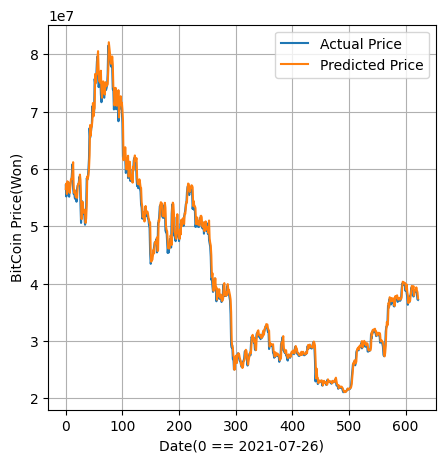

Mean of Error Rate: 1.9900000000000002 %
Below 5% of Error Rate: 92.60000000000001 %
Predicted Price / Actual Price: 1.007
Estimated profit rate: 43.7 %
(2021-07-26 ~ 2023-05-10)


In [ ]:
import matplotlib.pyplot as plt

testPredictY = model.predict(shaped_testX)
var1 = testY
var2 = testPredictY.T[0]
graphX = [i for i in range(len(var1))]
plt.figure(figsize=(5,5))
plt.plot(graphX,var1)
plt.plot(graphX,var2)
plt.ylabel(ylabel="BitCoin Price(Won)")
plt.xlabel(xlabel="Date(0 == 2021-07-26)")
plt.legend(["Actual Price","Predicted Price"])
plt.grid()
plt.show()

# print(var1[:10])
# print(var2[:10])
accuracy = (np.absolute(var2-var1))/var1
howClose = (var2/var1)
print(f"Mean of Error Rate: {np.round(accuracy.mean(),4)*100} %")
print(f"Below 5% of Error Rate: {round(np.count_nonzero(np.round(accuracy,2)<=0.05)/accuracy.shape[0],3)*100} %")
print(f"Predicted Price / Actual Price: {round(howClose.mean(),3)}")

Money = 0
for i in range(var1.shape[0]):
  if i == 0:
    Money = var1[i]
  elif Money * 101/100 <= var2[i]:
    if high_test_data_y[i] >= var2[i]:
      Money = var2[i]
    else:
      Money = var1[i]
  else:
    pass

print(f"Estimated profit rate: {round((Money-var1[0])/var1[0],3)*100} %")
# 계산 대충 했기 때문에 정확하지 않음(=알고리즘이 틀렸을 수도 있음)
print("(2021-07-26 ~ 2023-05-10)")

For Saving the Model

In [ ]:
Save_Model_Name = "mark1_0_1"
model.save(f'./drive/MyDrive/Colab Notebooks/Mark1/saved_model/{Save_Model_Name}')

### 결론: 5% 이하의 오차율로는 90% 이상의 예측율 기록하였다

학습할때마다 예측률은 조금씩 바뀌므로 알아서 몇 번 돌리고 가장 예측률 좋은 것을 뽑아다가 쓰길 바란다.
그래프를 보다 싶이 추측값이 실제와 거의 유사한 그래프를 그렸다. 이제 이 프로그램을 24시간 돌려줄 컴퓨터가 필요하긴 하다. upbit api키와 계좌는 있어서 매수매도는 문제가 없으나 서버가 없다. 내 노트북을 24시간 켜 둘 수는 없지 않은가? 다음번에는 이더리움 예측도 해보겠다.

P.S. 사실 주식 예측을 할라 했는데 주식시장은 매일 열리는게 아니므로 데이터 조정이 까다롭다. 그렇다. 귀찮아서 주식 예측은 하지 않았다.


# 추가 실전 테스트 용 코드들:

종가 예측 모델 저장 및 불러오기 테스트 용 코드(잘 저장 됨)

In [ ]:
model.save('saved_model/mark1')
# model.save_weights('./mark1')

러닝 모델 불러오기

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model('saved_model/mark1')

# Check its architecture
new_model.summary()
# LoadPredictY = new_model.predict(shaped_testX)
# print(LoadPredictY[:10])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                7360      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 7,401
Trainable params: 7,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
!zip -r /content/saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/mark1/ (stored 0%)
  adding: content/saved_model/mark1/assets/ (stored 0%)
  adding: content/saved_model/mark1/saved_model.pb (deflated 90%)
  adding: content/saved_model/mark1/variables/ (stored 0%)
  adding: content/saved_model/mark1/variables/variables.index (deflated 58%)
  adding: content/saved_model/mark1/variables/variables.data-00000-of-00001 (deflated 54%)
  adding: content/saved_model/mark1/keras_metadata.pb (deflated 86%)
  adding: content/saved_model/mark1/fingerprint.pb (stored 0%)


In [ ]:
!unzip -qq ./saved_model.zip

업비트에서 최근 30일치 비트코인 시세 불러오기 코드(잘 호출 됨)

In [ ]:
import requests
import pandas as pd
import numpy as np

url = "https://api.upbit.com/v1/candles/days?market=KRW-BTC&count=31"
headers = {"accept": "application/json"}
response = requests.get(url, headers=headers)

# print(response.json())
responseList = []
for i in range(30):
  temp = response.json()[i+1]
  responseList.append([temp["candle_date_time_utc"],
                      temp["opening_price"],
                     temp["high_price"],
                     temp["low_price"],
                     temp["trade_price"],
                     temp["change_rate"],
                     ])

# print(responseList)
responseDF = pd.DataFrame(responseList)
reversed_idx = [i for i in range(len(responseList)-1,-1,-1)]
responseDF = pd.DataFrame(responseDF,index=reversed_idx)
responseDF = responseDF.reset_index(drop=True)
# print(responseDF.head())
print(responseDF.tail())
responseDF.drop(0,axis=1,inplace=True)


responseDF = np.array(responseDF)
moduleInput = responseDF.reshape(1,30,5)

                      0           1           2           3           4  \
25  2023-05-11T00:00:00  37072000.0  37232000.0  36260000.0  36411000.0   
26  2023-05-12T00:00:00  36413000.0  36554000.0  35262000.0  36341000.0   
27  2023-05-13T00:00:00  36341000.0  36662000.0  36143000.0  36374000.0   
28  2023-05-14T00:00:00  36382000.0  36800000.0  36193000.0  36415000.0   
29  2023-05-15T00:00:00  36420000.0  37200000.0  36204000.0  36632000.0   

           5  
25 -0.017804  
26 -0.001922  
27  0.000908  
28  0.001127  
29  0.005959  


최근 30일치 시세 데이터 기반으로 오늘 종가(다음 날 아침 9:00) 예측

In [ ]:
from datetime import datetime
predictedPrice = new_model.predict(moduleInput)

print(f"{datetime.today().strftime('%Y-%m-%d')} predicted Bitcoin Close Price(Won): {predictedPrice[0][0]} \\")

1/1 [==============================] - 1s 604ms/step
2023-05-16 predicted Bitcoin Close Price(Won): 35935056.0 \


In [ ]:
!pip install schedule
!pip install jwt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


스케듈 모듈 확인(작동 완료)
다만 그린위치 시간대일 경우 -9시간 설정

In [ ]:
import schedule
import time
from datetime import datetime
def Test():
  print("hello")
schedule.every().day.at("13:43").do(Test)

now = datetime.now()
print(now)
while(1):
  schedule.run_pending()
  time.sleep(1)

2023-05-16 13:42:21.556385
hello


KeyboardInterrupt: ignored

업비트 매수 테스트 용


colab ip

124.54.88.236,
13.114.132.81,
34.68.123.148

In [ ]:
!curl ipecho.net/plain

34.68.123.148

In [ ]:
!pip install pyupbit
!pip install PyJWT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 3.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip uninstall jwt
!pip uninstall PyJWT
!pip install PyJWT

Found existing installation: jwt 1.3.1
Uninstalling jwt-1.3.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/jwt-1.3.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/jwt/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.10/dist-packages/jwt/algorithms.py
    /usr/local/lib/python3.10/dist-packages/jwt/api_jwk.py
    /usr/local/lib/python3.10/dist-packages/jwt/api_jws.py
    /usr/local/lib/python3.10/dist-packages/jwt/api_jwt.py
    /usr/local/lib/python3.10/dist-packages/jwt/help.py
    /usr/local/lib/python3.10/dist-packages/jwt/jwk_set_cache.py
    /usr/local/lib/python3.10/dist-packages/jwt/jwks_client.py
    /usr/local/lib/python3.10/dist-packages/jwt/types.py
    /usr/local/lib/python3.10/dist-packages/jwt/warnings.py
Proceed (Y/n)? y
  Successfully uninstalled jwt-1.3.1
Found existing installation: PyJWT 2.7.0
Uninstalling PyJWT-2.7.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/PyJWT-2.7.0.dist-info/*
    /usr/local